In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
%matplotlib inline

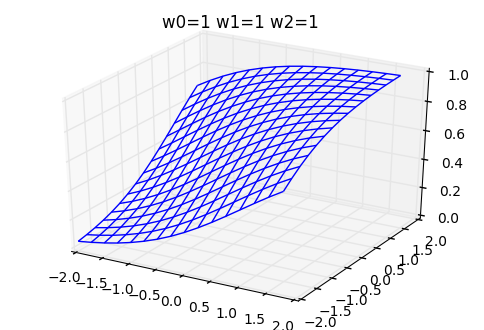

In [2]:
# created on 6th Jun 2017, by Wang Yi 
# logistic REGRESSION
def _sigmoid(z):
    return np.divide(1, 1+np.exp(-z))

def  sigmoid(w, X):
    if hasattr(X, "dot"):
        z = X.dot(w)
    elif hasattr(X, "__len__"):
        temp = map(lambda (i, mat): w[i] * mat, enumerate(X))
        z = reduce(lambda pre, curr: pre + curr, temp)
    else:
        z = X*w
    return _sigmoid(z)

def hypo_func(w, X):
    return _sigmoid(X.dot(w))

def hypo_mesh(w, X):
    temp = map(lambda (i, mesh): w[i] * mesh, enumerate(X))
    z = reduce(lambda pre, curr: pre + curr, temp)
    return _sigmoid(z)
    
def plot_hypothesis3D(w, ax=None):
    if ax is None:
        fig = plt.figure()
        ax = fig.gca(projection='3d')
    X, Y = np.mgrid[-2:2:0.25, -2:2:0.25]
    X0 = np.ones(X.shape)
    Z = hypo_mesh(w, (X0, X, Y)) # here is a mesh matrix array
    ax.plot_wireframe(X, Y, Z, cstride=1, rstride=1)
    ax.set_title("".join(map(lambda (i, v): "w{id}={val} ".format(id=i, val=v), enumerate(w))))
    # plt.show()
    return ax

plot_hypothesis3D(np.array((1,1,1)))

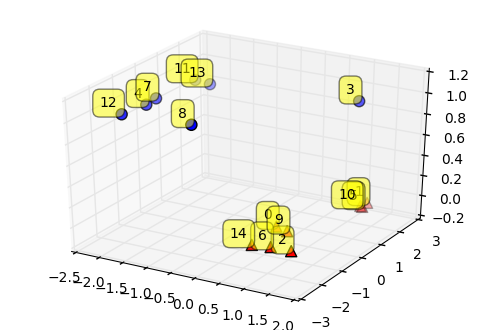

In [136]:
# data copy from internet
# ref http://cpmarkchang.logdown.com/posts/189069-logisti-regression-model

X0=np.array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
              1.,  1.])
X1=np.array([ 0.56,  1.40,  1.38,  1.25, -1.91,
              1.42,  0.97, -1.95, -0.65,  0.84,
              1.37, -1.90, -2.00 ,-1.54,  0.63])

X2=np.array([-0.55,  1.99, -1.78,  1.75, -0.99,
              1.68, -1.79, -0.47, -1.72, -0.69,
              1.71,  1.22, -1.88,  1.11, -1.89])

Z =np.array([-0.20, -0.10, -2.69,  0.02,  4.42,
             -0.36, -1.89,  4.88,  1.40, -0.87,
             -0.25,  5.97,  3.98,  5.15, -1.28])
# Z = (Z - np.min(Z))/(np.max(Z) - np.min(Z)) * 1

def plot_data(ax=None):
    if ax is None:
        fig = plt.figure(dpi=60)
        ax = fig.gca(projection='3d')
    ax.scatter(X1[Z>=0], X2[Z>=0], np.ones( X1[Z>=0].shape) ,c='b',marker='o', s = 64)
    ax.scatter(X1[Z< 0], X2[Z< 0], np.zeros(X1[Z< 0].shape) ,c='r',marker='^', s = 64)
    
    for i,x,y in zip(range(len(X1)), X1, X2):
        p,q,_ = proj3d.proj_transform(x,y,1 if Z[i] >=0 else 0, ax.get_proj())
        ax.annotate("%s" % i, xy=(p,q), xytext=(-3, 3), textcoords='offset points', ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5))#arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        # ax.annotate("%s" % i, xy=(p,q))
        # ax.text(x,y,Z[i], '%s' % (str(i)), size=20, color='red')
    # plt.show()
    return ax

ax = plot_data()

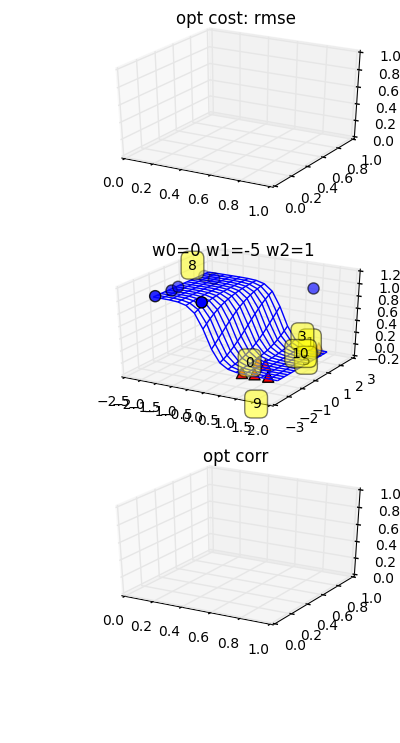

In [121]:
def user_plot(w):
    # plt.style.use('ggplot')
    fig = plt.figure(figsize=plt.figaspect(2.))
    ax_rmse = fig.add_subplot(3, 1, 1, projection='3d')              
    ax_rmse.set_title("opt cost: rmse")
    ax_logloss = fig.add_subplot(3, 1, 2, projection='3d')
    ax_logloss.set_title("opt cost: logloss")
    ax_corr = fig.add_subplot(3, 1, 3, projection='3d')
    ax_corr.set_title("opt corr")
    
    plot_data(ax=ax_logloss)
    plot_hypothesis3D(w, ax=ax_logloss)
    
    plt.show()
    
user_plot(np.array((0, -5, 1)))

In [122]:
EPILON = 1.0e-8

In [123]:
# decoratorLib from PEP 318 standard
def accepts(*types):
    def check_accepts(f):
        assert len(types) == f.func_code.co_argcount
        def new_f(*args, **kwds):
            for (a, t) in zip(args, types):
                assert isinstance(a, t), \
                       "arg %r does not match %s" % (a,t)
            return f(*args, **kwds)
        new_f.func_name = f.func_name
        return new_f
    return check_accepts

def returns(rtype):
    def check_returns(f):
        def new_f(*args, **kwds):
            result = f(*args, **kwds)
            assert isinstance(result, rtype), \
                   "return value %r does not match %s" % (result,rtype)
            return result
        new_f.func_name = f.func_name
        return new_f
    return check_returns

# add cost adaptor for fmin_cg
def cost_adaptor(*args, **kw):
    def wrapper(f):
        def adaptor(theta):
            return f(theta, *args, **kw)
        return adaptor
    return wrapper

In [124]:
# lrCostFunc
# created at 14/12/15, 11:40 AM by WANG YI, lwang019@e.ntu.edu.sg
# updated on 6th Jun, 2017 by WANG YI, lwang11@mtu.edu
#   1. add line search
#   2. support corr supervised learning
# ALL RIGHTS RESERVED

def logloss(p, q):
    return np.sum(cross_entropy(p, q), axis=0) 
    
def cross_entropy(p, q):
    print("q(sigmoid): %s" % np.array2string(q, formatter={'float_kind':'{0:6.3f}'.format}))
    print("p(y): %s" % np.array2string(p, formatter={'float_kind':'{0:6.3f}'.format}))
    print("entropy: %s" % np.array2string(-p * np.log(q) - (1-p) * np.log(1-q), formatter={'float_kind':'{0:6.3f}'.format}))
    return -p * np.log(q) - (1-p) * np.log(1-q)

def lasso(theta):
    ret = np.abs(theta)
    if hasattr(theta, "__len__"):
        ret[0] = 0
    return ret

# You might also want to use approximate function here
# for more information please refer to Proximal Gradient Methods, the following equation is equivalent to Proximal Gradient Methods
def lasso_G(theta, epilon=EPILON):
    if hasattr(theta, "__len__"):
        p = len(theta)
        ret = np.array(map(lambda i: np.sign(theta[i]) if np.abs(theta[i]) >= epilon else 0, np.arange(p)))
    else:
        ret = np.sign(theta) if np.abs(theta) >= epilon else 0
    return ret

learning_rate = 0.1
@cost_adaptor(np.column_stack([X0, X1, X2]), Z, sigmoid, learning_rate, lasso, lasso_G)
def lrCostFunc(theta, X, y, hypo, _lambda, reg_f, reg_G):
    n, p = X.shape
    if reg_G is not None and reg_f is not None:
        reg = reg_f(theta)
        # grad = 1.0/n * (X.T).dot(sigmoid(theta, X) - y) + 1.0/(2*n) * _lambda * reg_G(reg, epilon=_lambda) 
        grad = np.array(map(lambda i: 1.0/n * X[:,i].dot(sigmoid(theta, X) - y) +  1.0/n * _lambda * reg_G(reg[i], epilon=_lambda), np.arange(p)))
        J = 1.0/n * logloss(y, sigmoid(theta, X)) + _lambda/(2*n) * np.sum(reg)
    else:
        # grad = 1.0/n * (X.T).dot(sigmoid(theta, X) - y)
        grad = np.array(map(lambda i: 1.0/n * X[:,i].dot(sigmoid(theta, X) - y), np.arange(p)))
        J = 1.0/n * logloss(y, sigmoid(theta, X))
        # grad = np.array(map(lambda i: 1.0/n * np.sum(sigmoid(y, X.dot(theta))*y*X[:,i]), np.arange(p)))
        # J = 1.0/n * np.sum(np.log(1 + np.exp(-y * X.dot(theta))))
    return (J, grad)

# derived from max likelyhood
@cost_adaptor(np.column_stack([X0, X1, X2]), Z, sigmoid, learning_rate, lasso, None)
def lr_entropy(theta, X, y, hypo, _lambda, reg_f, reg_g):
    n, p = X.shape
    temp_err = np.divide(1, 1 + np.exp(y * X.dot(theta)))
    grad = np.array(map(lambda i: np.average(temp_err * (-y * X[:, i])), np.arange(p)))
    J = 1.0/n * np.sum( np.divide(1, 1 + np.exp(y * X.dot(theta))) )
    return (J, grad)

# X0 will be replaced by a step func
@cost_adaptor(np.column_stack([X1, X2]), Z, sigmoid, learning_rate, lasso, None)
def corr(theta, X, y, hypo, V, _lambda, reg_f, reg_g):
    pass

def wolf_powell(f, fk, xk, lr, g):
    c1 = 0.01
    c2 = 0.8
    EPILON = 0.01
    p = - g
    alpha = 1.0
    
    maxIter = 4
    i = 0
    flag1 = True
    flag2 = True
    print("begin line search")
    while (flag1 or flag2) and i < maxIter:
        fkplus = f(xk + alpha * p)
        temp1 = fkplus[0] - fk + c1 * alpha * g.dot(p)
        flag1 = temp1 > 0
        temp2 = fkplus[1].dot(p) - c2 * g.dot(p)
        flag2 = temp2 < 0 and np.abs(temp2) < EPILON
        print(" f(xk + alpha*p)  =%6.2f %2s  fk+c1*alpha*g@p=%6.2f" % (fkplus[0], '>' if flag1 else '<=', fk + c1 * alpha * g.dot(p)))
        print("df(xk + alpha*p)*p=%6.2f %2s           c2*g@p=%6.2f" % (fkplus[1].dot(p), '<' if flag2 else '>=', c2 * g.dot(p)))
        alpha = alpha*(1.0 - alpha / 2)
        i += 1
    print("end line search")
    print("step ratio %6.2f" % alpha)
    return alpha

def fmin_cg(cost, init_param, options={}):
    gifseq = options['gifseq']
    maxIter = options['maxIter']
    weights = init_param
    lr = options['learning_rate']
    line_search = options['line_search']
    alpha = int(1)
    user_call = options['user_call']
    hypo = options['hypo']
    i = 0
    J0 = 10
    while i < maxIter:
        J1, grad = cost(weights)
        print("Iteration %s, error %s" % (i, J1))
        print("grad %s" % grad)
        if np.abs(J0 - J1) < EPILON and grad.dot(grad) < EPILON:
            print("convergent! at iteration %s" % i)
            print("with weights %s" % weights)
            print("grad %s" % grad)
            break
        # linear search here
        if line_search:
            alpha = wolf_powell(cost, J1, weights, lr, grad)
            weights = weights - alpha * grad
        else:
            weights = weights - lr * grad
            
        if user_call and i in gifseq:
            user_call(weights)
        J0 = J1
        i += 1
    return weights

def batch(mat, ratio=1.0):
    r, _ = mat.shape
    return randperm(mat)[:int(r*ratio) + 1]

def randperm(mat):
    return np.random.permutation(mat)

def InitalizWeights(*size):
    return np.random.rand(*size)

q(sigmoid): [ 0.624  0.968  0.570  0.956  0.097  0.960  0.469  0.136  0.164  0.660
  0.959  0.402  0.045  0.464  0.370]
p(y): [-0.200 -0.100 -2.690  0.020  4.420 -0.360 -1.890  4.880  1.400 -0.870
 -0.250  5.970  3.980  5.150 -1.280]
entropy: [ 1.080  3.791  1.596  3.058  9.986  4.365  0.401  9.149  2.456  1.653
  3.987  2.896 12.220  1.361 -0.221]
Iteration 0, error 3.85780046819
grad [-0.68909533  3.9897236  -0.16430072]
begin line search
q(sigmoid): [ 0.244  0.240  0.008  0.282  0.997  0.179  0.027  0.999  0.798  0.108
  0.208  1.000  0.995  0.999  0.065]
p(y): [-0.200 -0.100 -2.690  0.020  4.420 -0.360 -1.890  4.880  1.400 -0.870
 -0.250  5.970  3.980  5.150 -1.280]
entropy: [ 0.055  0.159 -12.982  0.349 -20.212 -0.350 -6.774 -25.401 -0.324 -1.726
 -0.102 -40.113 -15.791 -28.520 -3.348]
 f(xk + alpha*p)  =-10.33 <=  fk+c1*alpha*g@p=  3.69
df(xk + alpha*p)*p=-12.85 >=           c2*g@p=-13.14
end line search
step ratio   0.50
q(sigmoid): [ 0.423  0.756  0.093  0.744  0.863  0.696  0.

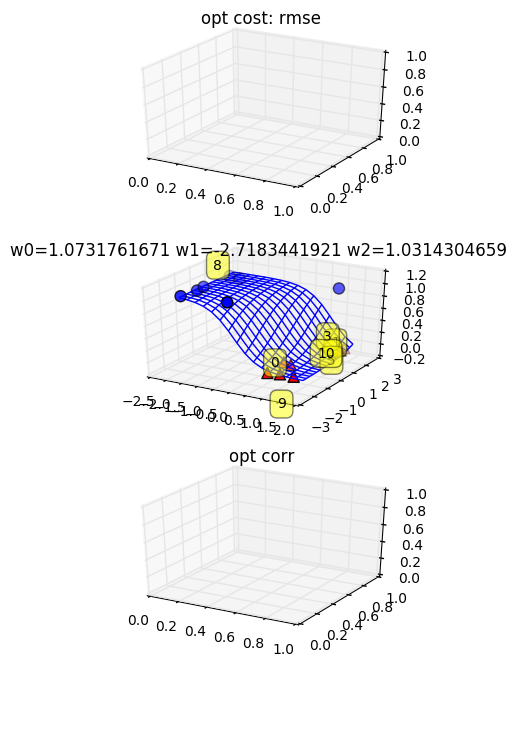

q(sigmoid): [ 0.266  0.336  0.011  0.373  0.995  0.258  0.032  0.997  0.744  0.128
  0.292  0.999  0.990  0.998  0.070]
p(y): [-0.200 -0.100 -2.690  0.020  4.420 -0.360 -1.890  4.880  1.400 -0.870
 -0.250  5.970  3.980  5.150 -1.280]
entropy: [ 0.106  0.342 -12.132  0.477 -17.930 -0.080 -6.412 -22.847 -0.130 -1.536
  0.123 -37.256 -13.611 -26.576 -3.241]
Iteration 2, error -9.36778688296
grad [-0.71274943  3.11140991 -0.45992274]
begin line search
q(sigmoid): [ 0.091  0.032  0.000  0.053  1.000  0.018  0.001  1.000  0.953  0.016
  0.025  1.000  1.000  1.000  0.009]
p(y): [-0.200 -0.100 -2.690  0.020  4.420 -0.360 -1.890  4.880  1.400 -0.870
 -0.250  5.970  3.980  5.150 -1.280]
entropy: [-0.364 -0.308 -23.978  0.112 -39.140 -1.417 -12.356 -48.318 -1.156 -3.586
 -0.887 -72.969 -31.712 -51.539 -6.014]
 f(xk + alpha*p)  =-19.55 <=  fk+c1*alpha*g@p= -9.47
df(xk + alpha*p)*p=-10.11 >=           c2*g@p= -8.32
end line search
step ratio   0.50


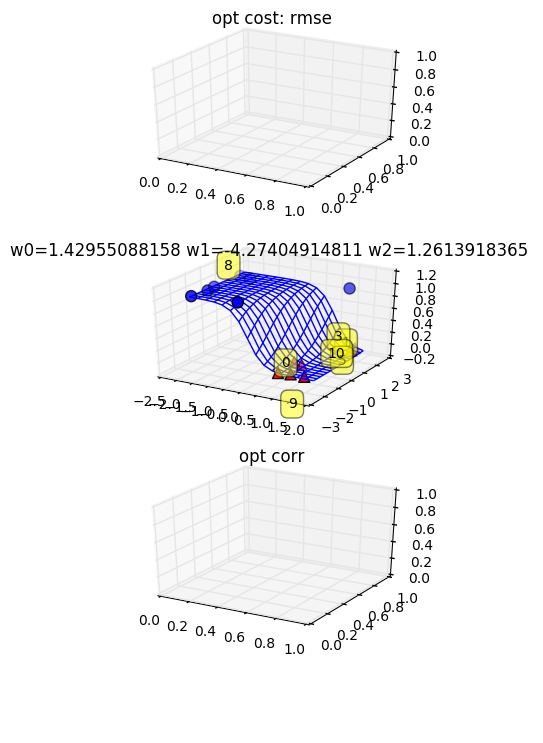

q(sigmoid): [ 0.160  0.115  0.001  0.154  1.000  0.074  0.007  1.000  0.885  0.046
  0.094  1.000  1.000  1.000  0.025]
p(y): [-0.200 -0.100 -2.690  0.020  4.420 -0.360 -1.890  4.880  1.400 -0.870
 -0.250  5.970  3.980  5.150 -1.280]
entropy: [-0.157 -0.083 -18.059  0.201 -28.537 -0.830 -9.394 -35.584 -0.693 -2.590
 -0.469 -55.113 -22.666 -39.059 -4.643]
Iteration 3, error -14.4931876229
grad [-0.77466842  3.01545313 -0.55833043]
begin line search
q(sigmoid): [ 0.053  0.012  0.000  0.024  1.000  0.006  0.000  1.000  0.978  0.006
  0.009  1.000  1.000  1.000  0.003]
p(y): [-0.200 -0.100 -2.690  0.020  4.420 -0.360 -1.890  4.880  1.400 -0.870
 -0.250  5.970  3.980  5.150 -1.280]
entropy: [-0.521 -0.426 -29.844  0.098 -48.994 -1.826 -15.354 -60.386 -1.503 -4.496
 -1.158 -90.823 -39.819 -64.117 -7.456]
 f(xk + alpha*p)  =-24.41 <=  fk+c1*alpha*g@p=-14.59
df(xk + alpha*p)*p= -9.92 >=           c2*g@p= -8.00
end line search
step ratio   0.50


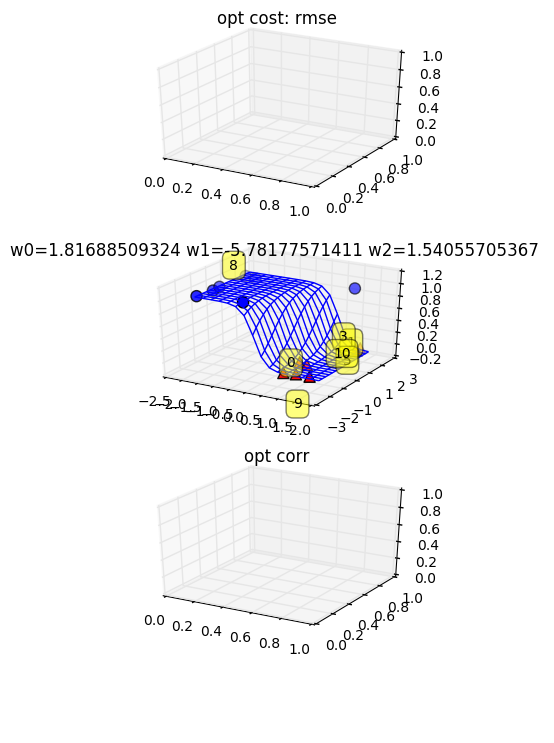

In [127]:
option = {
    'maxIter': 4,
    'learning_rate': 1,
    'watch': None,
    'user_call': user_plot,
    'line_search': True,
    'hypo': hypo_func,
    'gifseq': [1,2,3, 10, 30, 60, 80, 100, 200, 299, 300, 1000]
}

theta = InitalizWeights(3)
w = fmin_cg(lrCostFunc, init_param=theta, options=option)

In [95]:
# step func test
def map_decl(f):
    tbl = {}
    def wrap(idx):
        if tbl.get(idx, None) is not None:
            print("idx: %d" % idx)
            return tbl[idx]
        return f(idx)
    return wrap

@map_decl
def alpha(i):
    if i == 0:
        return 1.0
    return alpha(i-1) * (1 - alpha(i-1) / 2)

for i in range(20):
    print("%6.3f" % alpha(i))

 1.000
 0.500
 0.375
 0.305
 0.258
 0.225
 0.200
 0.180
 0.164
 0.150
 0.139
 0.129
 0.121
 0.114
 0.107
 0.101
 0.096
 0.092
 0.087
 0.084


In [147]:
# Created on 10th June 2017
# ref: https://en.wikipedia.org/wiki/Otsu's_method
# In the following articles we also represent that: "K-Means++ are equivalent to Otsu method"
#  1. Dongju Liu and Jian Yu. 2009. Otsu Method and K-means. In Proceedings of the 2009 Ninth International Conference on Hybrid Intelligent Systems - Volume 01 (HIS '09), Vol. 1. IEEE Computer Society, Washington, DC, USA, 344-349. DOI=http://dx.doi.org/10.1109/HIS.2009.74
#  2. http://yiakwy.github.io/blog/2017/05/31/natural-philosophy-of-supervised-or-semisupervised-model-generalization
# But Otsu is more theoretically robust(please refer to above 2nd non-official article). However, Otsu method opt procedure is not competitive to the K-Means "lloyd" iteration

def var(xi, miu, p):
    return (xi - miu).dot((xi - miu) * p)

def otsu_func(pseu_hist, *t):
    # pseu_hist : [(xi, t), ...]
    l = len(t) - 1
    sigma = [None] * l
    xi, p, row_no = [np.array(arr) for arr in zip(*pseu_hist)]
    p = np.abs(p) / np.sum(np.abs(p))
    q, miu = np.zeros(l), np.zeros(l)
    for i in range(l):
        q[i] = np.sum(p[t[i]:t[i+1]])
        miu[i] = np.sum(p[t[i]:t[i+1]].dot(xi[t[i]:t[i+1]]))
        sigma[i] = var(xi[t[i]:t[i+1]], miu[i], p[t[i]:t[i+1]] / q[i])
    return (np.array(sigma).dot(q), sigma)

INF = float("inf")

def Box_Threshold(mtx, target, hypo_func, options={}):
    # each op grad update will give us presumed clusters
    n, p = mtx.shape
    m = [(hypo_func(xi), target[i], i) for i, xi in enumerate(mtx)]
    pseu_hist = sorted(m, key=lambda row: row[0])
    xi, p, row_no = [np.array(arr) for arr in zip(*pseu_hist)]
    p = np.abs(p) / np.sum(np.abs(p))
    # t0 < t1 < ... 
    plt.barh(xi, p, height=0.05, align='center')
    plt.show()
    print(np.array2string(np.array(zip(row_no, p)), formatter={'float_kind':'{0:6.3f}'.format}))
    
    # linear optimizer
    def binary_find(h, s, e, p=1):
        sigma_w = INF
        idx = -1
        print("begin binary_find:")
        for t in range(s, e, p):
            sigma_curr = otsu_func(h, s, t, e)[0]
            print("curr weigthed variance within class: %6.3f at pos %d" %(sigma_curr, t))
            if  sigma_w > sigma_curr:
                sigma_w = sigma_curr
                idx = t
        print("end binary_find")
        return (sigma_w, idx)
    
    start, end = 0, n
    ret_part = []
    ret = []
    stack = [(start, end)]
    step = 0
    maxIter = options.get("maxIter", 5)
    
    while len(stack) != 0 and step < maxIter:
        start, end = stack.pop(-1)
        sigma_w, t = binary_find(pseu_hist, start, end)
        print("Iteration %s, within-class variance is: %6.3f at index %s" % (step, sigma_w, t))
        print("(start, end): <%s, %s>" % (start, end))
        sigma = otsu_func(pseu_hist, start, t, end)[1]
        next_step = np.argmax(sigma)
        print("segment result at step %s:" % (step))
        print(" Left with var {}:".format(sigma[0]))
        print(np.array2string(np.array(zip(row_no[start:t], p[start:t])), formatter={'float_kind':'{0:6.3f}'.format}))
        print("Right with var {}:".format(sigma[1]))
        print(np.array2string(np.array(zip(row_no[t:end], p[t:end])), formatter={'float_kind':'{0:6.3f}'.format}))
        
        if t == start or t == end:
            # we should not divide it any more
            continue
        stack.extend([(t, end), (start, t)] if next_step % 2 == 0 else [(start, t), (t, end)])
        ret_part.append(t)
        step += 1
    
    ret_part.sort()
    if ret_part[ 0] != 0: ret_part.insert(0, 0)
    if ret_part[-1] != n: ret_part.append(n)
    l = len(ret_part)- 1
    print("part points: %s" %  str(ret_part))
    for i in range(l):
        clique = (i,[int(row[2]) for row in pseu_hist[ret_part[i]:ret_part[i+1]]])
        ret.append(clique)
    return ret

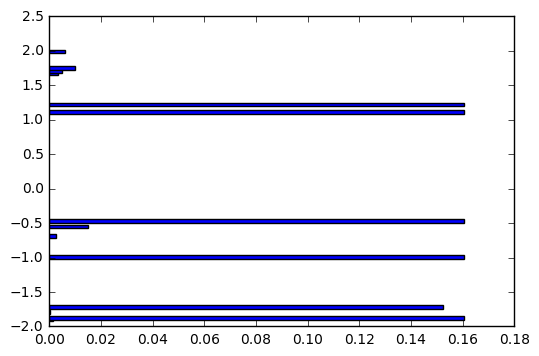

[[14.000  0.001]
 [12.000  0.161]
 [ 6.000  0.000]
 [ 2.000  0.000]
 [ 8.000  0.153]
 [ 4.000  0.161]
 [ 9.000  0.003]
 [ 0.000  0.015]
 [ 7.000  0.161]
 [13.000  0.161]
 [11.000  0.161]
 [ 5.000  0.003]
 [10.000  0.005]
 [ 3.000  0.010]
 [ 1.000  0.006]]
begin binary_find:
curr weigthed variance within class:  1.585 at pos 0
curr weigthed variance within class:  1.587 at pos 1
curr weigthed variance within class:  1.560 at pos 2
curr weigthed variance within class:  1.560 at pos 3
curr weigthed variance within class:  1.560 at pos 4
curr weigthed variance within class:  1.158 at pos 5
curr weigthed variance within class:  0.772 at pos 6
curr weigthed variance within class:  0.767 at pos 7
curr weigthed variance within class:  0.747 at pos 8
curr weigthed variance within class:  0.563 at pos 9
curr weigthed variance within class:  1.159 at pos 10
curr weigthed variance within class:  1.540 at pos 11
curr weigthed variance within class:  1.547 at pos 12
curr weigthed variance within cla

In [151]:
cliques = Box_Threshold(np.column_stack([X1, X2]), sigmoid(w, np.column_stack([X0, X1, X2])), lambda x: x[1])

for clique in cliques:
    print("clique-<%d>: %s" % (clique[0] ,
                              ", ".join(map(lambda i: str(i), clique[1]))
                             )
         )

['yellow' 'green' 'yellow' 'green' 'yellow' 'green' 'yellow' 'yellow'
 'yellow' 'yellow' 'green' 'green' 'yellow' 'green' 'yellow']


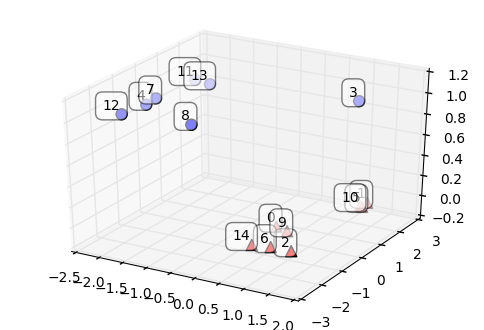

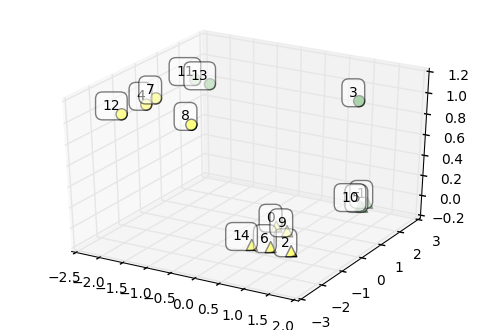

In [152]:
def plot_data(ax=None, group=None):
    if ax is None:
        fig = plt.figure(dpi=60)
        ax = fig.gca(projection='3d')
    if group is None:
        ax.scatter(X1[Z>=0], X2[Z>=0], np.ones( X1[Z>=0].shape) ,c='b',marker='o', s = 64)
        ax.scatter(X1[Z< 0], X2[Z< 0], np.zeros(X1[Z< 0].shape) ,c='r',marker='^', s = 64)
    else:
        ax.scatter(X1[Z>=0], X2[Z>=0], np.ones( X1[Z>=0].shape) ,c=group[Z>=0], marker='o', s = 64)
        ax.scatter(X1[Z< 0], X2[Z< 0], np.zeros(X1[Z< 0].shape) ,c=group[Z< 0], marker='^', s = 64)
    
    for i,x,y in zip(range(len(X1)), X1, X2):
        p,q,_ = proj3d.proj_transform(x,y,1 if Z[i] >= 0 else 0, ax.get_proj())
        ax.annotate("%s" % i, xy=(p,q), xytext=(-1, 1), textcoords='offset points', ha='right', va='bottom', bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.5))#arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
        # ax.annotate("%s" % i, xy=(p,q))
        # ax.text(x,y,Z[i], '%s' % (str(i)), size=20, color='red')
    # plt.show()
    return ax

def assign(i, color_map):
    l = len(cliques)
    for clique in cliques:
        ix, c = clique
        if i in c:
            return color_map[ix]
    return "white"

color_map = ["yellow", "green", "blue"]
group = np.array(map(lambda i: assign(i, color_map), range(len(Z))))
print(group)
plot_data()
plot_data(group=group)

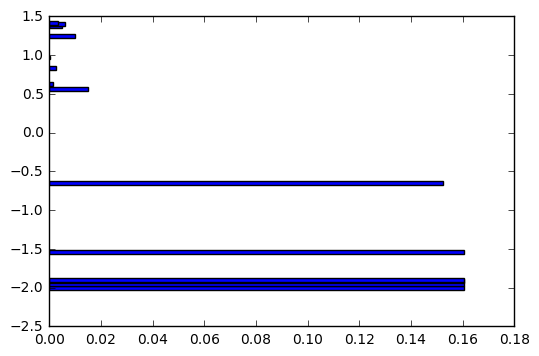

[[12.000  0.161]
 [ 7.000  0.161]
 [ 4.000  0.161]
 [11.000  0.161]
 [13.000  0.161]
 [ 8.000  0.153]
 [ 0.000  0.015]
 [14.000  0.001]
 [ 9.000  0.003]
 [ 6.000  0.000]
 [ 3.000  0.010]
 [10.000  0.005]
 [ 2.000  0.000]
 [ 1.000  0.006]
 [ 5.000  0.003]]
begin binary_find:
curr weigthed variance within class:  0.517 at pos 0
curr weigthed variance within class:  0.978 at pos 1
curr weigthed variance within class:  1.136 at pos 2
curr weigthed variance within class:  1.024 at pos 3
curr weigthed variance within class:  0.657 at pos 4
curr weigthed variance within class:  0.239 at pos 5
curr weigthed variance within class:  0.262 at pos 6
curr weigthed variance within class:  0.329 at pos 7
curr weigthed variance within class:  0.336 at pos 8
curr weigthed variance within class:  0.350 at pos 9
curr weigthed variance within class:  0.351 at pos 10
curr weigthed variance within class:  0.417 at pos 11
curr weigthed variance within class:  0.450 at pos 12
curr weigthed variance within cla

In [153]:
cliques = Box_Threshold(np.column_stack([X1, X2]), sigmoid(w, np.column_stack([X0, X1, X2])), lambda x: x[0])

for clique in cliques:
    print("clique-<%d>: %s" % (clique[0] ,
                              ", ".join(map(lambda i: str(i), clique[1]))
                             )
         )

['blue' 'blue' 'blue' 'blue' 'yellow' 'blue' 'blue' 'yellow' 'green' 'blue'
 'blue' 'yellow' 'yellow' 'yellow' 'blue']


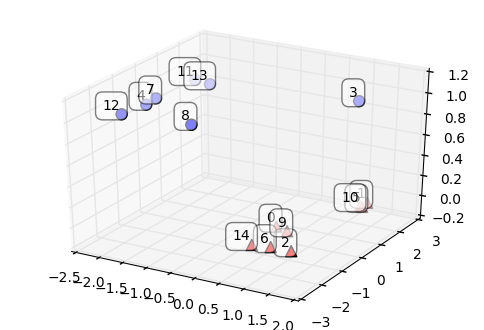

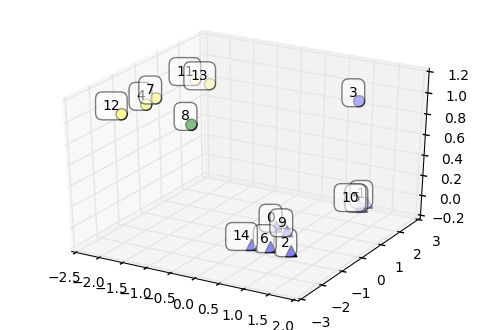

In [154]:
group = np.array(map(lambda i: assign(i, color_map), range(len(Z))))
print(group)
plot_data()
plot_data(group=group)

## Here we got our step function \-\- Cliques
Look at green points, 